In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## Model Architecture - 1 Hidden Layer with 50 nodes

In [2]:
class NN(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [4]:
train_dataset = datasets.MNIST(root='datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to the device
        data = data.to(device)
        targets = targets.to(device)

        
        # Reshape the data
        data = data.reshape(data.shape[0], -1)
        
        # Forward pass
        scores = model(data)
        
        # Calculate the loss
        loss = loss_fn(scores, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [7]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on the train dataset")
    else:
        print("Checking accuracy on the test dataset")
    
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
        print("Accuracy: {:.2f}%".format(accuracy))
            
    model.train()
    return

In [8]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on the train dataset
Accuracy: 99.58%
Checking accuracy on the test dataset
Accuracy: 97.72%


In [9]:
from PIL import Image, ImageOps
import torchvision.transforms as transforms

def predict(image_path):

        
    image = Image.open(image_path).convert("1")  # Convert to grayscale
    image = ImageOps.invert(image)

    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values
    ])
    # Apply the transformations to the image
    image_tensor1 = transform(image)
    
    # Add a batch dimension to the tensor
    image_tensor = image_tensor1.unsqueeze(0)
    
    # Move the tensor to the device (CPU or GPU)
    image_tensor = image_tensor.to(device)
    
    # Reshape the tensor to match the input shape of the model
    image_tensor = image_tensor.reshape(image_tensor.shape[0], -1)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make predictions on the image
    with torch.no_grad():
        scores = model(image_tensor)
        _, predicted = scores.max(1)
        predicted_class = predicted.item()
    
    return predicted_class

In [10]:
predict("six.jpg")

4

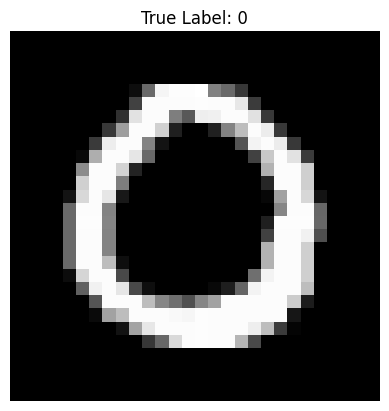

Predicted Class: 0
True Label: 0


In [11]:
import random
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a random index from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image and label at the random index
image, label = test_dataset[random_index]

# Display the image using matplotlib
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()

# Preprocess the image tensor for input to the model
image_tensor = image.unsqueeze(0)  # Add a batch dimension
image_tensor = image_tensor.to(device)  # Move the tensor to the device (CPU or GPU)
image_tensor = image_tensor.reshape(image_tensor.shape[0], -1)  # Reshape the tensor

# Make a prediction using the trained model
with torch.no_grad():
    scores = model(image_tensor)
    _, predicted = scores.max(1)
    predicted_class = predicted.item()

print("Predicted Class:", predicted_class)
print("True Label:", label)
